# Classifying HIP and mainstream violinists 

## Preliminaries

In [0]:
import sys
!rm -rf spotipy
!git clone https://github.com/plamere/spotipy
!cd spotipy; python setup.py install
sys.path.append('spotipy')
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials('e316c18604cb42399f3b679791362112','4bd95a0d37d145998cfdcaf2a68579d7')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
%matplotlib inline

Cloning into 'spotipy'...
remote: Enumerating objects: 1366, done.
remote: Total 1366 (delta 0), reused 0 (delta 0), pack-reused 1366
Receiving objects: 100% (1366/1366), 513.62 KiB | 5.52 MiB/s, done.
Resolving deltas: 100% (860/860), done.
running install
running bdist_egg
running egg_info
creating spotipy.egg-info
writing spotipy.egg-info/PKG-INFO
writing dependency_links to spotipy.egg-info/dependency_links.txt
writing requirements to spotipy.egg-info/requires.txt
writing top-level names to spotipy.egg-info/top_level.txt
writing manifest file 'spotipy.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'spotipy.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/spotipy
copying spotipy/oauth2.py -> build/lib/spotipy
copying spotipy/util.py -> build/lib/spotipy
copying spotipy/client.py -> build/lib/spotipy
copying spotipy/__init__.py ->

In [0]:
# # Can ignore this
# import csv
# from google.colab import files, drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Tatums and segments
The code below takes a recording by Hilary Hahn and puts the start times of all the tatums and segments into big lists, which are then converted to .csv files. The goal of this was to see what constitutes a tatum and what constitutes a segment, since they appear to be automatically generated.

In [0]:
# Hilary Hahn playing Bach's Allemande from the Partita no. 2 in D minor, BWV 1004.
test = sp.audio_analysis('spotify:track:5S94PIQplSfBHZXsZowyGY')

In [0]:
# let's try to make a csv of the tatum start times
tatums = [tatum['start'] for tatum in test['tatums']]
with open('tatums.csv', 'w', newline='') as myfile:
  wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
  for tatum in tatums:
    wr.writerow([tatum])

segments = [segment['start'] for segment in test['segments']]
with open('segments.csv', 'w', newline='') as myfile:
  wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
  for segment in segments:
    wr.writerow([segment])

# this worked :) we get one duration per row of the csv file.

sections = [section['start'] for section in test['sections']]
print(len(tatums), len(segments), len(sections))

806 1361 21


In [0]:
# Christoph Poppen playing the same piece
test2 = sp.audio_analysis('spotify:track:6t4kqUufnqr5ACAmCWyBM3')
tatums2 = [tatum['start'] for tatum in test2['tatums']]
segments2 = [segment['start'] for segment in test2['segments']]
sections2 = [section['start'] for section in test2['sections']]

In [0]:
print(len(tatums2), len(segments2), len(sections2))

1050 984 13


There are actually more tatums in Poppen's recording than Hahn's, but more segments in Hahn's than Poppen's. The difference in the number of sections I think is an artefact because this audio property is more tailored to pop songs.

### What did I do with the .csvs above? What did they tell me?
I grabbed the audio file for Hilary Hahn's performance from YouTube (you can't do it from Spotify as easily, but this comes to pretty much the same thing save maybe for a slight alignment issue) and imported it into Sonic Visualiser software, which displays it as a waveform. 

This software allows you to add annotation layers to your waveforms, and even sonify them, to see and hear how the original audio lines up with these annotations. The annotations came from the .csv files I listed above. You get something that looks a bit like this when you superimpose the segment boundaries onto the waveform:

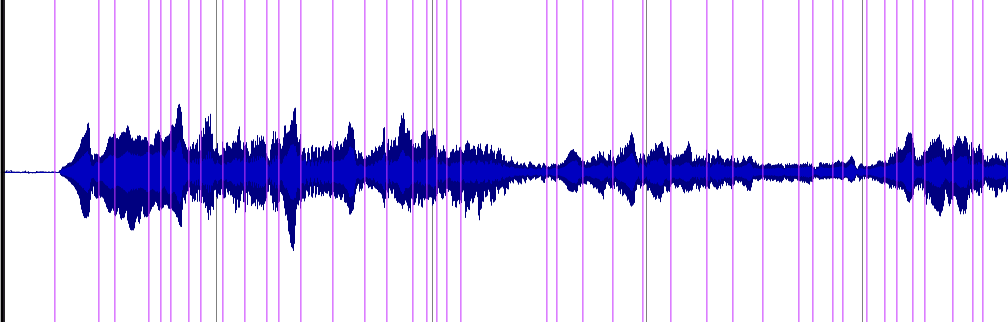

I had a listen to the results, and there doesn't seem to be much of a pattern to the segment boundaries. Some of them line up with note onsets, but a lot of them don't. I wonder whether it's something to do with vibrato, or any bow "hiss" that creeps in from time to time. Hilary Hahn plays with a decent amount of bow pressure, and perhaps she was pretty closely miked.

Tatums were distributed very regularly across the track, but again nothing seemed to line up especially meaningfully. The Allemande is in 4/4 time but the tatums sounded like they were in a triple metre. So I get the impression they're not especially reliable. 

The fact that timbral information is only encoded at the level of the segment doesn't preclude us from using those data. But we'll have to find some way to resample and interpolate so that everything is at the same level of granularity. I won't start out with doing this.

## Beats and bars
We're going to see how many beats and bars there are in the two recordings. Hopefully they'll be around the same, so that we can draw meaningful comparisons.

In [0]:
# Hahn
beats = [beat['start'] for beat in test['beats']]
bars = [bar['start'] for bar in test['bars']]
print(len(beats), len(bars))

403 101


In [0]:
# Poppen
beats2 = [beat['start'] for beat in test2['beats']]
bars2 = [bar['start'] for bar in test2['bars']]
print(len(beats2), len(bars2))

525 131


Alas, they're not the same, BUT Hilary Hahn doesn't do the second repeat while Poppen does. Since the beat and bar lengths of his recording are around 30% longer than Hahn's, let's see if a different recording that does the second repeat has the same number of bars. Itzhak Perlman fits the bill for this comparison.

In [0]:
# Perlman
test3 = sp.audio_analysis('spotify:track:4ikovZbQZv14rJ2sIEisSM')
beats3 = [beat['start'] for beat in test3['beats']]
bars3 = [bar['start'] for bar in test3['bars']]
print(len(beats3), len(bars3))

545 136


This is more promising! I'm going to inspect the bars manually in sonic visualiser for both recordings, just so I have a sense of what they're finding. For reference, there are 32 bars in the Allemande, and both halves are repeated giving 64. It seems like just over double the number of bars are being detected in each case, but it's not clear why the number is more than twice.

In [0]:
with open('perlman_bars.csv', 'w', newline='') as myfile:
  wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
  for bar in bars3:
    wr.writerow([bar])

with open('poppen_bars.csv', 'w', newline='') as myfile:
  wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
  for bar in bars2:
    wr.writerow([bar])

I had a look and it seemed like the Perlman bars were on average too short. However, this may not be the case for everyone. There's perhaps still some theories that we can test about tempo based on whether someone is an HIP performer or not, but for the time being I'm going to explore a different Bach movement where these problems aren't as likely to arise.

## J.S. Bach, Partita for solo violin in E major, BWV 1006, I. Preludio
This movement has no accompaniment, no repeats, a very consistent rhythm, and only a couple of chords near the end, so it's much easier to do the audio analysis. My goal is to see what kind of audio features might help group performers into HIP and 'mainstream' camps.

It's pretty difficult to find tracks automatically using the queries. This piece has been arranged for multiple instruments, so using the `sp.search()` function produced mandolin, cello and guitar recordings among others. I'm only interested in violin recordings. So I handpicked a few violinists, about half of whom are generally considered to be HIP performers, and the other half considered to be more mainstream performers.

In [0]:
hip_violinists = {'Thomas Zehetmair': 'spotify:track:2PWQgfuZ3uCevoubNquege',
                  'Enrico Onofri':'spotify:track:2hdJcQJpxpx5dsruaspZCz',
                  'Lucy van Dael':'spotify:track:2SgVIgMQf6BOMkLCcfQqay',
                  'Amandine Beyer':'spotify:track:5Tanv8uCE36cv5Dpa2a3Rt',
                  'Sergiu Luca':'spotify:track:0DBX3Wg1d9bvVG8IROaHHG',
                  'Monica Huggett':'spotify:track:6J5Zyzq1SIpuWBOf3HtwCl',
                  'Viktoria Mullova':'spotify:track:6Se7Mzy3nUx1HJIMDVLKM3',
                  'Giuliano Carmignola':'spotify:track:6o46WzLu70oigEdUbd5ntJ',
                  'Rachel Podger':'spotify:track:3iWTTNnXsfkV3ngXK1i549'}

mainstream_violinists = {'Hilary Hahn':'spotify:track:2sqhid2MBYJCZWPrLjsUbP',
                         'Itzhak Perlman':'spotify:track:5fHmHXEiORUWp4bUdjcZ35',
                         'Arthur Grumiaux':'spotify:track:3anzrDNu9oU7Is5qoZqJGS',
                         'Henryk Szeryng':'spotify:track:0ryVQLFLnd9PmnRLFfOQFv',
                         'Midori Goto':'spotify:track:72RQcAkUtka38wq5RHWsOG',
                         'Kyung Wha Chung':'spotify:track:4sQR57WSxtSpuUwZQYhO0z',
                         'Gidon Kremer':'spotify:track:5uyB0nvACy8gqvSbCfRjDD',
                         'Aaron Rosand':'spotify:track:5y0VnDke5RoPDYllFU3sQ6',
                         'Lara St. John':'spotify:track:7rnaLaHs2b7GB4y7ratcQJ'}

all_violinists = hip_violinists
all_violinists.update(mainstream_violinists)

In [0]:
duration_info = {}
for violinist in all_violinists:
  audio_info = sp.audio_analysis(all_violinists[violinist])
  duration_info[violinist] = {}
  if violinist not in mainstream_violinists:
    duration_info[violinist]['hip'] = True
  else:
    duration_info[violinist]['hip'] = False
  for division in ['bars','beats','sections','segments','tatums']:
    duration_info[violinist]['n_' + division] = len(audio_info[division])
    duration_info[violinist]['mean_' + division] = np.mean([d['duration'] for d in audio_info[division]])
    duration_info[violinist]['std_' + division] = np.std([d['duration'] for d in audio_info[division]])
  duration_info[violinist]['track_duration'] = audio_info['track']['duration']
  print(f'finished {violinist}')

finished Thomas Zehetmair
finished Enrico Onofri
finished Lucy van Dael
finished Amandine Beyer
finished Sergiu Luca
finished Monica Huggett
finished Viktoria Mullova
finished Giuliano Carmignola
finished Rachel Podger
finished Hilary Hahn
finished Itzhak Perlman
finished Arthur Grumiaux
finished Henryk Szeryng
finished Midori Goto
finished Kyung Wha Chung
finished Gidon Kremer
finished Aaron Rosand
finished Lara St. John


In [0]:
duration_table = pd.DataFrame(data=duration_info).transpose()

In [0]:
# saving this table because it took a long time to generate. surprisingly long. 
duration_table.to_json('drive/My Drive/Year1/Corpus_Studies/Colab Notebooks/Spotipy/Final_Project/duration_data.json')

In [0]:
# load table
duration_table = pd.read_json('drive/My Drive/Year1/Corpus_Studies/Colab Notebooks/Spotipy/Final_Project/duration_data.json')
display(duration_table)

,hip,n_bars,mean_bars,std_bars,n_beats,mean_beats,std_beats,n_sections,mean_sections,std_sections,n_segments,mean_segments,std_segments,n_tatums,mean_tatums,std_tatums,track_duration
Thomas Zehetmair,True,97,2.254029,0.661638,390,0.565971,0.147343,12,18.765554,18.455134,1228,0.183377,0.159891,780,0.283324,0.122495,225.18667
Enrico Onofri,True,116,1.957430,0.156671,463,0.492505,0.013946,12,19.376667,7.489433,1222,0.190278,0.142447,926,0.246253,0.006973,232.52000
Lucy van Dael,True,114,2.049725,0.119647,457,0.514613,0.018664,12,20.014444,8.725067,1255,0.191373,0.131882,914,0.257307,0.009332,240.17333
Amandine Beyer,True,113,1.935986,0.072829,452,0.485168,0.016165,12,18.612222,16.011450,1155,0.193374,0.153494,904,0.242584,0.008083,223.34667
Sergiu Luca,True,145,1.563139,0.102859,434,0.524116,0.009736,12,19.213334,9.947102,1326,0.173876,0.107587,868,0.262058,0.004868,230.56000
Monica Huggett,True,144,1.684535,0.329825,434,0.563637,0.096071,10,25.163999,9.287689,1461,0.172238,0.163127,868,0.282093,0.106908,251.64000
Viktoria Mullova,True,112,1.883104,0.142093,448,0.473843,0.012835,12,18.143333,7.317922,1173,0.185610,0.160392,896,0.236922,0.006417,217.72000
Giuliano Carmignola,True,112,2.036180,0.180183,449,0.513782,0.016847,12,19.912222,11.285000,1320,0.181020,0.206374,898,0.256891,0.008423,238.94667
Rachel Podger,True,145,1.429398,0.092510,438,0.475812,0.017586,12,18.261110,7.561361,1138,0.192560,0.292619,876,0.237906,0.008794,219.13333
Hilary Hahn,False,144,1.435792,0.058733,433,0.479100,0.011926,11,19.478786,7.759187,1287,0.166485,0.183850,866,0.239550,0.005963,214.26667


## t tests
We're going to go through each column in the table and see if the means of the number of time divisions in each category are significantly different between HIP and mainstream performers.

Spotify lists what each time division means:
- **bars**:	The time intervals of the bars throughout the track. A bar (or measure) is a segment of time defined as a given number of beats. Bar offsets also indicate downbeats, the first beat of the measure.
- **beats**:	The time intervals of beats throughout the track. A beat is the basic time unit of a piece of music; for example, each tick of a metronome. Beats are typically multiples of tatums.
- **sections**:	Sections are defined by large variations in rhythm or timbre, e.g. chorus, verse, bridge, guitar solo, etc. Each section contains its own descriptions of tempo, key, mode, time_signature, and loudness.
- **segments**:	Audio segments attempts to subdivide a song into many segments, with each segment containing a roughly consitent sound throughout its duration.
- **tatums**:	A tatum represents the lowest regular pulse train that a listener intuitively infers from the timing of perceived musical events (segments). For more information about tatums, see Rhythm (below).

In [0]:
from scipy.stats import ttest_ind

In [0]:
categories = [category for category in duration_table.columns if category != 'hip']
t_test_duration_info = {}
for category in categories:
  hip = duration_table[duration_table['hip']][category]
  mainstream = duration_table[duration_table['hip'] == False][category]
  t_test_duration_info[category] = list(ttest_ind(hip,mainstream,axis=None))
  if t_test_duration_info[category][1] <= 0.05:
    t_test_duration_info[category].append('S')
  elif t_test_duration_info[category][1] <= 0.10:
    t_test_duration_info[category].append('s')
  else:
    t_test_duration_info[category].append('NS')

In [0]:
t_test_duration_table = pd.DataFrame(t_test_duration_info).transpose()
t_test_duration_table.rename(columns={0: 't_statistic', 1: 'p_val',2:'significant'},inplace=True)
display(t_test_duration_table)

,t_statistic,p_val,significant
n_bars,-0.489294,0.631274,NS
mean_bars,0.496016,0.626627,NS
std_bars,1.18191,0.25451,NS
n_beats,0.933434,0.36447,NS
mean_beats,-0.156627,0.877498,NS
std_beats,1.47606,0.159338,NS
n_sections,2.04265,0.0579234,s
mean_sections,-0.460721,0.651199,NS
std_sections,-0.441828,0.664527,NS
n_segments,0.760386,0.458084,NS


Seems like most of these metrics don't hold much information. That said, we can examine the three parameters that are significant or approach significance to see what's going on. We're basically just going to compare the means to see which type of player gives higher values.

In [0]:
for category in ['n_sections','mean_segments','track_duration']:
  hip_mean = np.mean(duration_table[duration_table['hip']][category])
  mainstream_mean = np.mean(duration_table[duration_table['hip']==False][category])
  higher = 'hip' if hip_mean > mainstream_mean else 'mainstream'
  true_significance = 'this approached significance' if t_test_duration_table.loc[category]['significant'] == 's' else ''
  print(f'for category {category}, the {higher} violinists have a higher mean: hip = {hip_mean:.4f}, mainstream = {mainstream_mean:.4f}, {true_significance}')

for category n_sections, the hip violinists have a higher mean: hip = 11.7778, mainstream = 10.5556, this approached significance
for category mean_segments, the hip violinists have a higher mean: hip = 0.1849, mainstream = 0.1754, this approached significance
for category track_duration, the hip violinists have a higher mean: hip = 231.0252, mainstream = 210.2459, 


Therefore, it seems that HIP violinists play this Bach Preludio slower. Their segments also last longer on average, which is probably just a function of the overall slower tempo. Finally, the fact that they have more sections on average suggests that they vary their timbre or tempo more frequently than the mainstream players. Given that the mean and standard deviation of the duration of a section are not significantly different between groups, we might reason that they're altering their timbre more than their tempo.

## Timbres: averages, standard deviations, timecourses

First let's make the big data table with every segment represented. This actually doesn't take too long :)

In [0]:
timbre_timecourses = {}
for violinist in all_violinists:
  audio_info = sp.audio_analysis(all_violinists[violinist])
  timbres = [d['timbre'] for d in audio_info['segments']]
  timbre_timecourses[violinist] = timbres
  print(f'finished {violinist}')

finished Thomas Zehetmair
finished Enrico Onofri
finished Lucy van Dael
finished Amandine Beyer
finished Sergiu Luca
finished Monica Huggett
finished Viktoria Mullova
finished Giuliano Carmignola
finished Rachel Podger
finished Hilary Hahn
finished Itzhak Perlman
finished Arthur Grumiaux
finished Henryk Szeryng
finished Midori Goto
finished Kyung Wha Chung
finished Gidon Kremer
finished Aaron Rosand
finished Lara St. John


In [0]:
# convert into big nested list format
timbre_timecourses_list = []
for violinist in timbre_timecourses.keys():
  all_timbres = timbre_timecourses[violinist]
  time_segment = 0
  for timbre in all_timbres:
    nest = []
    nest.append(violinist)
    if violinist not in mainstream_violinists:
      nest.append(True)
    else:
      nest.append(False)
    nest.append(time_segment)
    nest.extend(timbre)
    timbre_timecourses_list.append(nest)
    time_segment += 1
  print(f'finished {violinist}')

finished Thomas Zehetmair
finished Enrico Onofri
finished Lucy van Dael
finished Amandine Beyer
finished Sergiu Luca
finished Monica Huggett
finished Viktoria Mullova
finished Giuliano Carmignola
finished Rachel Podger
finished Hilary Hahn
finished Itzhak Perlman
finished Arthur Grumiaux
finished Henryk Szeryng
finished Midori Goto
finished Kyung Wha Chung
finished Gidon Kremer
finished Aaron Rosand
finished Lara St. John


In [0]:
col_names = ['violinist','hip','segment_no']
col_names.extend([f'timbre_{i+1}' for i in range(12)])

In [0]:
timbre_timecourses_table = pd.DataFrame(data=timbre_timecourses_list,columns=col_names)
display(timbre_timecourses_table)

,violinist,hip,segment_no,timbre_1,timbre_2,timbre_3,timbre_4,timbre_5,timbre_6,timbre_7,timbre_8,timbre_9,timbre_10,timbre_11,timbre_12
0,Thomas Zehetmair,True,0,0.615,159.108,-14.170,-38.581,39.524,-50.601,27.371,4.852,-24.882,6.074,-14.269,-7.823
1,Thomas Zehetmair,True,1,2.250,124.531,-60.446,-58.187,15.006,-49.780,33.356,3.084,-24.940,9.988,-12.335,-2.061
2,Thomas Zehetmair,True,2,40.695,196.262,121.605,8.508,57.646,108.492,15.080,38.492,-17.511,-4.032,63.901,18.237
3,Thomas Zehetmair,True,3,41.314,276.215,160.133,90.033,21.788,-1.029,22.967,-35.082,-35.329,-7.017,-10.728,60.971
4,Thomas Zehetmair,True,4,39.525,171.079,218.066,39.952,59.852,19.366,60.005,-3.814,-5.892,20.498,-65.150,20.719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22138,Lara St. John,False,913,17.369,151.124,-35.402,211.089,6.778,-59.538,-8.223,35.233,-13.741,-18.086,-61.141,29.718
22139,Lara St. John,False,914,2.449,120.290,-71.844,-53.741,9.263,-52.114,26.921,13.364,-26.551,5.640,-4.505,-2.078
22140,Lara St. John,False,915,2.852,111.167,-81.676,-55.256,6.619,-52.656,21.047,17.419,-27.041,1.649,-7.179,-0.630
22141,Lara St. John,False,916,2.473,119.435,-72.092,-59.281,8.631,-47.783,29.234,7.390,-29.056,11.040,-8.760,0.239


In [0]:
# save
timbre_timecourses_table.to_json('drive/My Drive/Year1/Corpus_Studies/Colab Notebooks/Spotipy/Final_Project/timbre_data.json')

In [0]:
# load
timbre_timecourses_table = pd.read_json('drive/My Drive/Year1/Corpus_Studies/Colab Notebooks/Spotipy/Final_Project/timbre_data.json')
display(timbre_timecourses_table)

,violinist,hip,segment_no,timbre_1,timbre_2,timbre_3,timbre_4,timbre_5,timbre_6,timbre_7,timbre_8,timbre_9,timbre_10,timbre_11,timbre_12
0,Thomas Zehetmair,True,0,0.615,159.108,-14.170,-38.581,39.524,-50.601,27.371,4.852,-24.882,6.074,-14.269,-7.823
1,Thomas Zehetmair,True,1,2.250,124.531,-60.446,-58.187,15.006,-49.780,33.356,3.084,-24.940,9.988,-12.335,-2.061
2,Thomas Zehetmair,True,2,40.695,196.262,121.605,8.508,57.646,108.492,15.080,38.492,-17.511,-4.032,63.901,18.237
3,Thomas Zehetmair,True,3,41.314,276.215,160.133,90.033,21.788,-1.029,22.967,-35.082,-35.329,-7.017,-10.728,60.971
4,Thomas Zehetmair,True,4,39.525,171.079,218.066,39.952,59.852,19.366,60.005,-3.814,-5.892,20.498,-65.150,20.719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22138,Lara St. John,False,913,17.369,151.124,-35.402,211.089,6.778,-59.538,-8.223,35.233,-13.741,-18.086,-61.141,29.718
22139,Lara St. John,False,914,2.449,120.290,-71.844,-53.741,9.263,-52.114,26.921,13.364,-26.551,5.640,-4.505,-2.078
22140,Lara St. John,False,915,2.852,111.167,-81.676,-55.256,6.619,-52.656,21.047,17.419,-27.041,1.649,-7.179,-0.630
22141,Lara St. John,False,916,2.473,119.435,-72.092,-59.281,8.631,-47.783,29.234,7.390,-29.056,11.040,-8.760,0.239


### Means and standard deviations

 Now let's get the means and standard deviations out.

In [0]:
timbres_averages_std = {}
for violinist in timbre_timecourses.keys():
  all_entries = timbre_timecourses_table[timbre_timecourses_table['violinist']==violinist]
  timbres_averages_std[violinist] = {}
  timbres_averages_std[violinist]['hip'] = violinist not in mainstream_violinists.keys()
  for i in range(12):
    timbres_averages_std[violinist][f'mean_timbre_{i+1}'] = np.mean(all_entries[f'timbre_{i+1}'])
    timbres_averages_std[violinist][f'std_timbre_{i+1}'] = np.std(all_entries[f'timbre_{i+1}'])

timbres_mean_std_table = pd.DataFrame(data=timbres_averages_std).transpose()

In [0]:
display(timbres_mean_std_table)

,hip,mean_timbre_1,std_timbre_1,mean_timbre_2,std_timbre_2,mean_timbre_3,std_timbre_3,mean_timbre_4,std_timbre_4,mean_timbre_5,std_timbre_5,mean_timbre_6,std_timbre_6,mean_timbre_7,std_timbre_7,mean_timbre_8,std_timbre_8,mean_timbre_9,std_timbre_9,mean_timbre_10,std_timbre_10,mean_timbre_11,std_timbre_11,mean_timbre_12,std_timbre_12
Thomas Zehetmair,True,37.1733,5.30839,61.6631,80.0654,116.647,53.3945,37.7923,35.1048,62.9858,25.4182,-10.9212,17.0577,-29.3658,32.1555,-9.9271,18.4216,-10.4723,16.2688,-1.35969,13.9638,-3.80247,13.1359,-4.67073,19.2845
Enrico Onofri,True,38.8511,4.78984,28.9139,75.7232,100.328,54.9414,26.5367,34.7846,76.269,28.1152,-13.6998,16.0665,-37.104,26.8425,-13.5283,17.56,1.99886,14.4256,3.17073,13.0974,-2.17686,12.6995,2.32645,18.3483
Lucy van Dael,True,40.2351,3.85456,37.4167,80.3181,109.911,53.6383,28.1226,34.0301,79.1331,31.0318,-11.6676,14.556,-37.2407,28.1157,-6.32578,16.7787,-0.907513,19.2385,1.86791,13.4934,-4.19133,12.477,-7.97237,19.5783
Amandine Beyer,True,38.495,4.50924,84.5767,79.6409,121.617,54.3373,42.5404,35.9996,72.8158,29.0629,-9.95835,18.5911,-34.6897,29.5182,-12.4245,17.5014,-3.70788,19.7915,4.21731,15.364,-4.35335,13.7247,-2.02176,18.8571
Sergiu Luca,True,38.3596,4.37625,47.9355,90.971,115.491,48.9837,43.6406,32.8243,71.9011,27.656,-5.62367,18.7646,-26.9783,31.9894,-2.39285,17.6759,-3.09259,22.2353,3.46136,13.376,-9.27851,13.5951,-10.3808,22.3209
Monica Huggett,True,35.9361,3.50754,32.6871,96.3497,96.9923,65.6171,33.916,38.0665,76.5799,29.0108,-6.61626,17.2595,-26.2381,41.3409,-4.8264,17.1086,-7.42747,19.3644,1.80989,14.8628,-8.36222,14.6775,-0.352807,23.2823
Viktoria Mullova,True,37.005,4.96537,65.1634,76.6693,130.713,49.8185,36.9191,30.922,73.5147,25.998,-10.1385,15.8469,-41.2646,28.0403,-8.12837,16.9124,-4.73473,15.5984,0.378234,13.0553,-2.27726,11.4416,-6.63661,20.9063
Giuliano Carmignola,True,39.4032,4.83785,102.315,81.6743,118.459,59.6077,37.7324,37.0525,78.0373,30.1818,-5.36025,17.2278,-43.7944,31.5361,-9.42757,18.467,-7.25544,19.0055,0.363301,14.5352,-6.7754,13.5738,0.549519,18.7481
Rachel Podger,True,40.6732,4.20684,71.868,88.1326,119.2,59.986,36.1064,36.5166,77.8783,32.3302,-13.1286,17.2301,-44.1345,28.5519,-11.7223,20.1663,-11.4309,16.9781,1.80349,15.9646,-1.57538,12.8088,-4.25917,17.3688
Hilary Hahn,False,39.1258,5.03171,88.8029,80.7258,114.572,57.4524,42.2187,32.6029,68.308,26.583,-6.41537,16.9221,-47.4888,38.0157,-10.9276,16.4966,-2.08382,18.4824,0.79525,12.8935,-5.26784,13.2387,-10.1215,18.7434


Time for some t-tests!

In [0]:
categories = [category for category in timbres_mean_std_table.columns if category != 'hip']
t_test_timbre_info = {}
for category in categories:
  hip = timbres_mean_std_table[timbres_mean_std_table['hip']][category]
  mainstream = timbres_mean_std_table[timbres_mean_std_table['hip'] == False][category]
  t_test_timbre_info[category] = list(ttest_ind(hip,mainstream,axis=None))
  if t_test_timbre_info[category][1] <= 0.05:
    t_test_timbre_info[category].append('S')
  elif t_test_timbre_info[category][1] <= 0.10:
    t_test_timbre_info[category].append('s')
  else:
    t_test_timbre_info[category].append('NS')

In [0]:
t_test_timbre_table = pd.DataFrame(t_test_timbre_info).transpose()
t_test_timbre_table.rename(columns={0: 't_statistic', 1: 'p_val',2:'significant'},inplace=True)
display(t_test_timbre_table)

,t_statistic,p_val,significant
mean_timbre_1,-0.253399,0.803187,NS
std_timbre_1,-1.25564,0.227273,NS
mean_timbre_2,-3.54259,0.00270858,S
std_timbre_2,-0.0851806,0.933175,NS
mean_timbre_3,-2.19243,0.0434797,S
std_timbre_3,-1.56761,0.136535,NS
mean_timbre_4,-3.01278,0.0082564,S
std_timbre_4,1.07477,0.298421,NS
mean_timbre_5,0.249639,0.806043,NS
std_timbre_5,1.51314,0.149745,NS


In [0]:
significant_categories = [category for category in t_test_timbre_info if t_test_timbre_info[category][2] != 'NS']
for category in significant_categories:
  hip_mean = np.mean(timbres_mean_std_table[timbres_mean_std_table['hip']][category])
  mainstream_mean = np.mean(timbres_mean_std_table[timbres_mean_std_table['hip']==False][category])
  higher = 'hip' if hip_mean > mainstream_mean else 'mainstream'
  true_significance = 'this approached significance' if t_test_timbre_info[category][2] == 's' else ''
  print(f'for category {category}, the {higher} violinists have a higher mean: hip = {hip_mean:.4f}, mainstream = {mainstream_mean:.4f}. {true_significance}')

for category mean_timbre_2, the mainstream violinists have a higher mean: hip = 59.1710, mainstream = 94.2560. 
for category mean_timbre_3, the mainstream violinists have a higher mean: hip = 114.3732, mainstream = 125.5084. 
for category mean_timbre_4, the mainstream violinists have a higher mean: hip = 35.9229, mainstream = 43.8996. 
for category std_timbre_7, the mainstream violinists have a higher mean: hip = 30.8989, mainstream = 34.3641. this approached significance
for category mean_timbre_9, the mainstream violinists have a higher mean: hip = -5.2255, mainstream = -1.3115. this approached significance
for category std_timbre_10, the hip violinists have a higher mean: hip = 14.1903, mainstream = 13.4633. this approached significance


This is pretty interesting: there are several timbral components that appear to exhibit significant differences between HIP and mainstream violinists. As a refresher, here are the basis functions that Spotify gives us for the segments:

 ![alt text](https://developer.spotify.com/assets/audio/Timbre_basis_functions.png)

Components 2, 3, 4 and 9 had higher means for the mainstream violinists than the HIP violinists. Some of the descriptions of these components are listed on the Spotify website.

Component 2 is linked to timbral "brightness". This is understandable when we think about the setup of modern violins, which have steel E strings and (usually) metal-wound lower strings that produce a brighter, more penetrating sound than gut strings.

Component 3 is linked to timbral "flatness". The higher mean for mainstream violinists may have something to do with the uniform, undecaying sound that modern bows are able to produce, as compared to the more "sculpted", decaying sound from baroque bows.

Component 4 is linked to strength of attack. Again, the greater attack from the mainstream players is probably due to the design of the modern bow, which promotes more "bite" at the start of the note than a baroque bow.

Component 9 is not described on the Spotify website. It seems like there are three bands of high intensity alternating with three bands of low intensity. Different instruments have different frequency spectra, and the violin is strongest in the fundamental frequency, and has some power at the first and third partial above the fundamental. Because the lowest band of component 9 is weak, we might expect negative loadings/weights on this component, and indeed this is what we have. In this data set, the HIP performers have a more negative weighting on that timbral component, so perhaps they have a stronger fundamental than the mainstream performers (or, conversely, weaker higher partials). Again, we might relate this to the setup of the instruments: baroque violins have gut strings, which have brightness but are less penetrating than their synthetic and metal counterparts. 

Components 7 and 10 have significantly different standard deviations between the groups. These components are a little harder to interpret, and may just be artefacts of the PCA that was most likely conducted to generate the basis functions. 

All of the violinists had a negative weighting on component 7, so the timbre profile of these segments is inverted compared with the image above. Perhaps this signals an attack with more low frequencies than high; a flat, bright sustain; and an increase in the lower partials toward the end of the segment. There is more variation in this component for mainstream violinists, but I don't know if we can read too much into this. 

Component 10 looks pretty much like the reverse of component 7 but with a little more spectral "bleeding". Again I'm not sure what it says that the HIP violinists have more variation in this component than the mainstream violinists. If anything I'd expect the variation to be higher in the mainstream violinists, but perhaps the extra variation in the HIP players is in the more fuzzy "bleeding" part.

### Timbre timecourses and clustering
I'm going to look at timecourses of some of the different timbre components. Since the number of segments is not the same across the different players, we're going to resample the timbre timecourses so that there are 1500 points in each one. This is higher than the highest number of segments, but it's a number that's easier to deal with than 1461 (the highest number of segments, which is in Monica Huggett's recording).

In [0]:
from scipy.signal import resample

In [0]:
timbre_resampled = {}
for violinist in timbre_timecourses.keys():
  timbre_resampled[violinist] = {}
  timbre_resampled[violinist]['hip'] = violinist not in mainstream_violinists.keys()
  all_timbres = timbre_timecourses[violinist]
  for i in range(12):
    original_timbre_tc = list(timbre_timecourses_table[timbre_timecourses_table['violinist']==violinist][f'timbre_{i+1}'])
    resampled_timbre_tc = resample(original_timbre_tc, 1500)
    timbre_resampled[violinist][f'timbre_{i+1}_resampled'] = resampled_timbre_tc

In [0]:
timbre_resampled_table = pd.DataFrame(timbre_resampled).transpose()

In [0]:
display(timbre_resampled_table)

,hip,timbre_1_resampled,timbre_2_resampled,timbre_3_resampled,timbre_4_resampled,timbre_5_resampled,timbre_6_resampled,timbre_7_resampled,timbre_8_resampled,timbre_9_resampled,timbre_10_resampled,timbre_11_resampled,timbre_12_resampled
Thomas Zehetmair,True,"[0.614999999999613, -1.842412227873415, 27.886...","[159.10799999999918, 133.15568699166346, 144.9...","[-14.170000000001098, -66.14789177002103, 46.3...","[-38.581000000000415, -64.23043118543191, -23....","[39.52399999999946, 14.85221865863117, 45.4175...","[-50.60099999999992, -65.41213437974075, 64.43...","[27.371000000000244, 34.476126449575574, 22.73...","[4.85200000000012, -9.724700866833633, 45.8770...","[-24.88199999999977, -29.520426391675908, -12....","[6.074000000000095, 9.609273846201928, 4.65680...","[-14.268999999999926, -21.727032676890175, 43....","[-7.822999999999989, -5.082052151452961, 8.789..."
Enrico Onofri,True,"[0.6079999999999781, 2.087882029877799, 12.638...","[159.89800000000005, 107.66115304357389, 150.2...","[-14.278999999999987, -51.88071304611917, 67.2...","[-38.00599999999999, -53.580006336206644, -102...","[38.69199999999996, 53.22341446197057, 13.9684...","[-52.82800000000002, -55.55349711984935, -10.5...","[30.75300000000006, 27.91984541574232, 35.1124...","[4.926000000000021, -5.334247226014565, 25.064...","[-22.427000000000007, -15.063330663227342, 2.1...","[5.3939999999999815, 13.719528970593215, -4.13...","[-13.800999999999998, -12.471170216846973, 26....","[-12.159999999999977, -13.691631082524733, 5.7..."
Lucy van Dael,True,"[0.29899999999988036, 0.9695416082392285, 16.2...","[164.69699999999978, 97.88387288611547, 189.67...","[0.6719999999995946, -83.55438363973333, 56.39...","[-36.76200000000013, -62.68374208513979, -142....","[50.75499999999986, 15.95210163082697, 3.95774...","[-50.94200000000002, -65.97114202660282, 38.25...","[19.069000000000074, 9.397538591425278, 71.098...","[-1.378999999999976, -9.836913256814022, 53.77...","[-27.44099999999999, -35.101730712913884, -1.1...","[2.704999999999965, 2.2645227637068643, -14.48...","[-12.216999999999937, -15.497964671096256, 39....","[-5.488999999999881, -3.621550776572084, 31.07..."
Amandine Beyer,True,"[2.0410000000000155, 24.814423596930993, 39.24...","[128.89700000000002, 235.58482202934786, 287.4...","[-59.758999999999986, 126.97903204937448, 211....","[-50.78999999999998, 8.881965224191525, 143.40...","[15.381000000000057, 15.890478738484974, 15.37...","[-50.120000000000005, 58.350344983315324, 79.8...","[27.340999999999976, 82.73957685871258, 100.94...","[11.709999999999987, 27.159814913214184, 4.952...","[-27.297, -28.168619618405835, -25.05596603692...","[8.074000000000003, 31.213770340222492, 38.571...","[-5.597000000000004, 25.20809959443845, 19.027...","[-2.0720000000000005, 26.983303212002802, 31.3..."
Sergiu Luca,True,"[3.5370000000000066, 33.448656584659076, 41.83...","[94.13800000000006, 306.79265188577585, 244.95...","[-89.721, 107.97499427433864, 198.733625110925...","[-69.50499999999998, -0.29081577766144584, 60....","[9.472999999999987, -5.322694470902159, 7.5865...","[-45.34299999999999, 163.65577766668594, 44.94...","[10.915999999999979, 67.24507423992836, 86.234...","[4.1459999999999955, 0.5073317071759448, 15.66...","[-33.096999999999994, -31.45160864647654, -5.8...","[8.848999999999991, 8.845811002059882, 10.1037...","[-8.382000000000014, 54.04524428233784, 5.3445...","[4.030000000000013, 12.408609071994203, 25.517..."
Monica Huggett,True,"[0.2839999999994416, 32.42512970052475, 34.603...","[164.93999999999872, 276.28533074774947, 270.1...","[1.5029999999982628, 128.15489379784395, 131.9...","[-36.46000000000029, 35.39310305178234, 113.19...","[51.50499999999872, 31.41110278152526, 36.9138...","[-50.97700000000016, 20.237540697541927, 32.77...","[18.320000000000114, 82.42330607204502, 60.818...","[-1.438000000000088, 4.928843624462922, 27.845...","[-27.568000000000104, -24.804193946602183, -33...","[2.293000000000005, -1.5526305909355071, -24.8...","[-11.7

Let's just plot all timecourses for one timbre parameter for the hell of it. It's going to look messy but we can at least see if there are any common patterns.

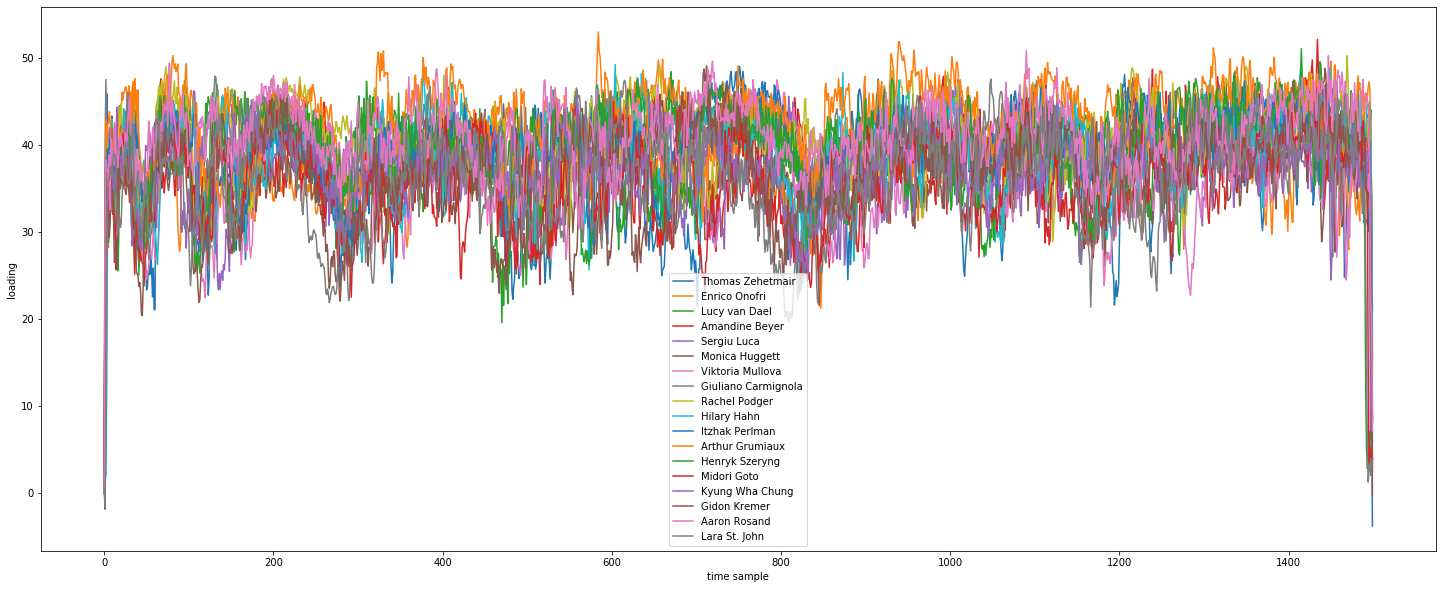

In [0]:
fig, ax = plt.subplots(figsize=(25,10))
for violinist in timbre_timecourses.keys():
  ax.plot(timbre_resampled_table.loc[violinist]['timbre_1_resampled'], label=violinist)
plt.xlabel('time sample')
plt.ylabel('loading')
plt.legend(loc='best')
plt.show()

Now let's try clustering the players using k-means clustering on the timecourses. We will probably find that 2 clusters is suboptimal, but we can test out a range of options.

In [0]:
from sklearn.cluster import KMeans

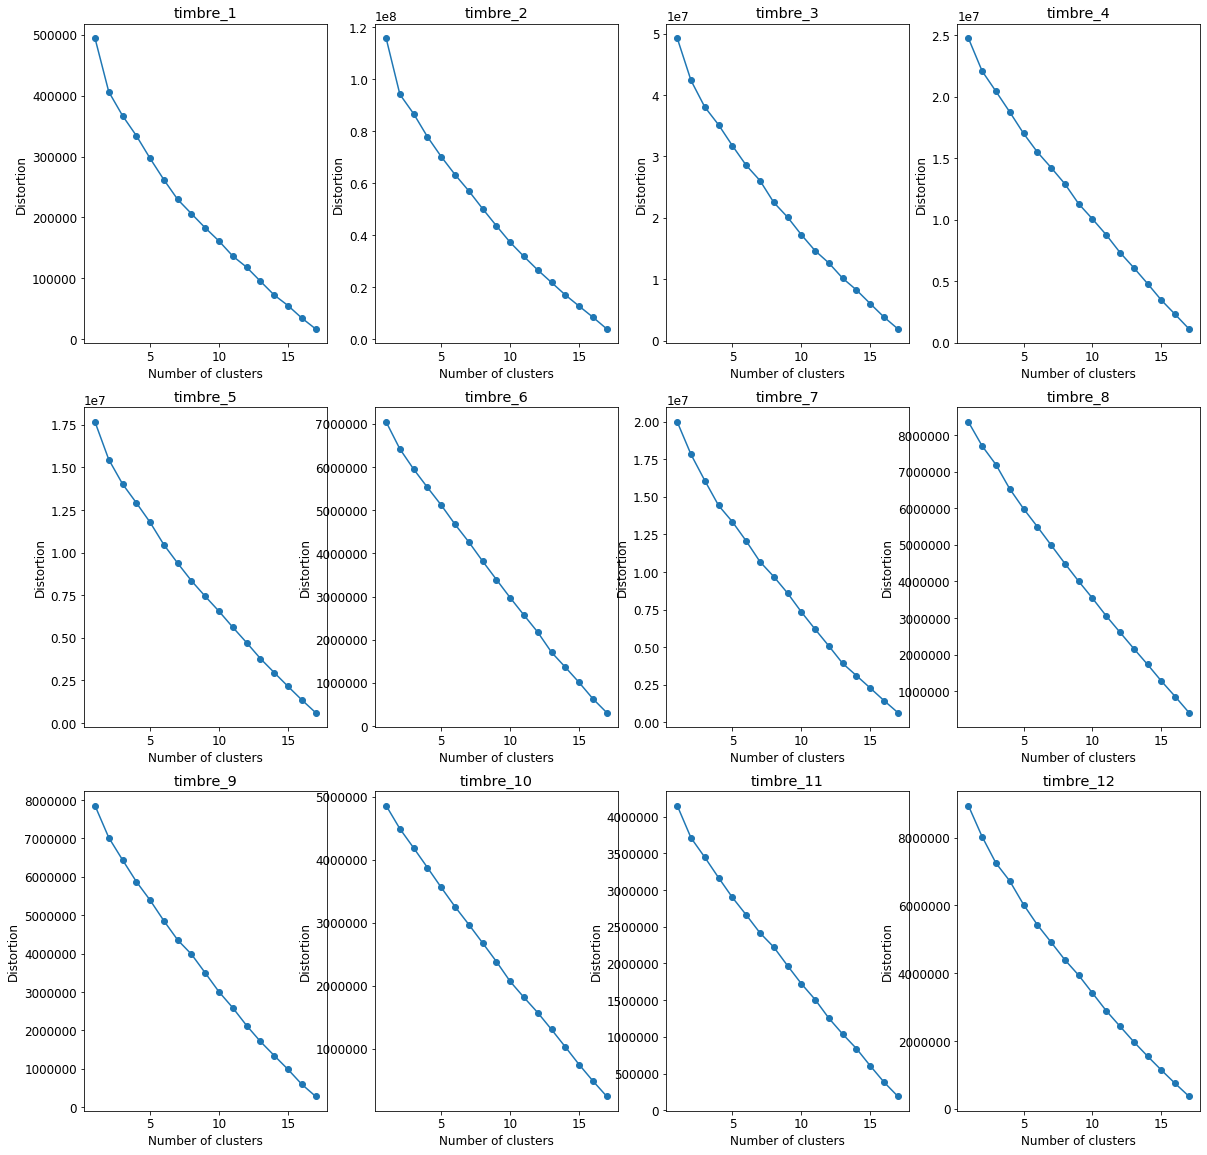

In [0]:
# optimal number of clusters?
f,a = plt.subplots(nrows=3,ncols=4,figsize=(20,20))
for i in range(12):
  distortions = []
  temp_table = pd.DataFrame(data={violinist: timbre_resampled_table.loc[violinist][f'timbre_{i+1}_resampled'] for violinist in timbre_timecourses.keys()}).transpose()
  for j in range(1, timbre_resampled_table.shape[0]):
      km = KMeans(
          n_clusters=j, init='random',
          n_init=10, max_iter=300,
          tol=1e-04, random_state=0
      )
      km.fit(temp_table)
      distortions.append(km.inertia_)
  del(temp_table)
  # plot
  plt.subplot(3,4,i+1)
  plt.plot(range(1, timbre_resampled_table.shape[0]), distortions, marker='o')
  plt.xlabel('Number of clusters')
  plt.ylabel('Distortion')
  plt.title(f'timbre_{i+1}')

plt.show()

There's going to be a lot of distortion in every case. I reckon that we should focus on components 1 to 4 for the clustering, since these have the clearest kink at 2 clusters.

In [0]:
clusters_timbre = {}
for i in range(4):
  # this is horribly written sorry!!!!
  km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=1e-04, 
              random_state=0).fit(pd.DataFrame(data={violinist: timbre_resampled_table.loc[violinist][f'timbre_{i+1}_resampled'] for violinist in timbre_timecourses.keys()}).transpose())
  results = km.predict(pd.DataFrame(data={violinist: timbre_resampled_table.loc[violinist][f'timbre_{i+1}_resampled'] for violinist in timbre_timecourses.keys()}).transpose())
  clusters = {}
  for j in range(len(timbre_timecourses.keys())):
    if results[j] not in clusters:
      clusters[results[j]] = []
    clusters[results[j]].append(list(timbre_timecourses.keys())[j])
  clusters_timbre[f'timbre_{i+1}'] = clusters

In [0]:
display(clusters_timbre)

{'timbre_1': {0: ['Thomas Zehetmair',
   'Monica Huggett',
   'Midori Goto',
   'Kyung Wha Chung',
   'Gidon Kremer',
   'Lara St. John'],
  1: ['Enrico Onofri',
   'Lucy van Dael',
   'Amandine Beyer',
   'Sergiu Luca',
   'Viktoria Mullova',
   'Giuliano Carmignola',
   'Rachel Podger',
   'Hilary Hahn',
   'Itzhak Perlman',
   'Arthur Grumiaux',
   'Henryk Szeryng',
   'Aaron Rosand']},
 'timbre_2': {0: ['Amandine Beyer',
   'Giuliano Carmignola',
   'Hilary Hahn',
   'Itzhak Perlman',
   'Henryk Szeryng',
   'Midori Goto',
   'Kyung Wha Chung',
   'Gidon Kremer',
   'Aaron Rosand',
   'Lara St. John'],
  1: ['Thomas Zehetmair',
   'Enrico Onofri',
   'Lucy van Dael',
   'Sergiu Luca',
   'Monica Huggett',
   'Viktoria Mullova',
   'Rachel Podger',
   'Arthur Grumiaux']},
 'timbre_3': {0: ['Henryk Szeryng',
   'Kyung Wha Chung',
   'Gidon Kremer',
   'Aaron Rosand',
   'Lara St. John'],
  1: ['Thomas Zehetmair',
   'Enrico Onofri',
   'Lucy van Dael',
   'Amandine Beyer',
   'Sergiu

Let's see how well they did!

In [0]:
from sklearn.metrics import homogeneity_score

In [0]:
ground_truth_hip = [1 if violinist not in mainstream_violinists else 0 for violinist in timbre_timecourses.keys()]
clusters_timbre_performance = {}
for timbre in clusters_timbre:
  temp_categories = [0 if violinist in clusters_timbre[timbre][0] else 1 for violinist in timbre_timecourses.keys()]
  clusters_timbre_performance[timbre] = homogeneity_score(ground_truth_hip, temp_categories)

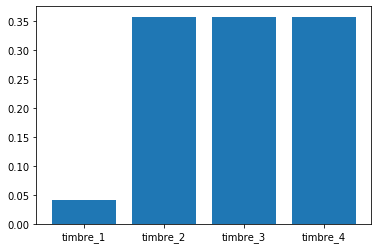

In [0]:
plt.bar(clusters_timbre_performance.keys(), clusters_timbre_performance.values())
plt.show()

Hmm...not so well, it seems. There's probably too much variation in these timecourses to capture anything meaningful. Let's see if smoothing the timecourses (low-pass filtering them) gives us anything better. I chose a second-order Butterworth filter with a cutoff frequency of $0.1 \times \frac{f_s}{2}$ (half the sampling rate).

In [0]:
from scipy import signal

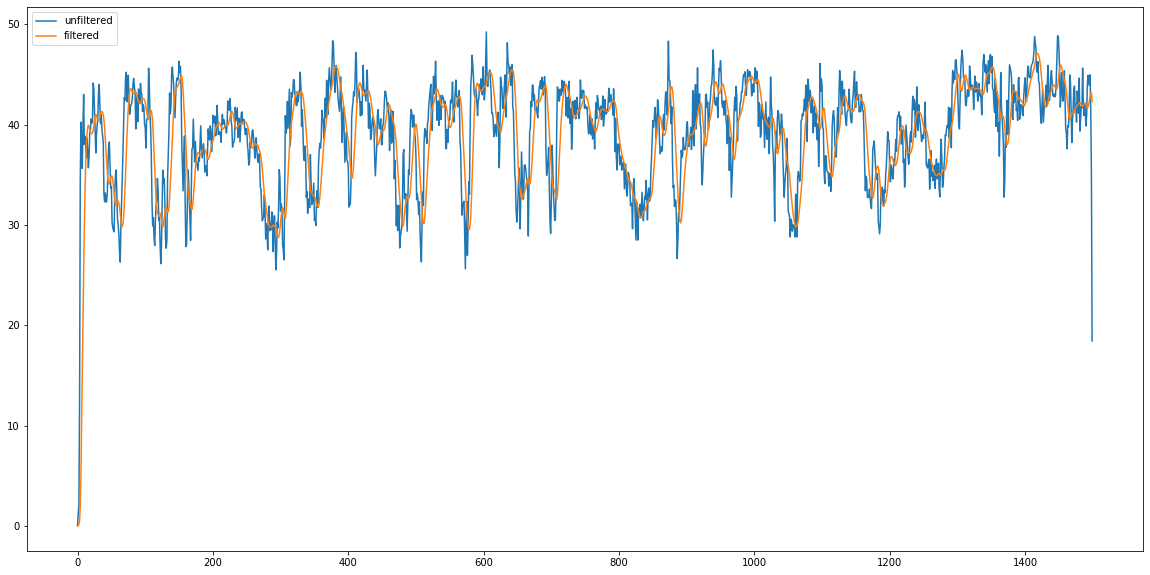

In [0]:
# look at what a smoothed version looks like!
b,a = signal.butter(2,0.1)
original = timbre_resampled_table.loc['Hilary Hahn']['timbre_1_resampled']
filtered = signal.lfilter(b,a,original)
plt.figure(figsize=(20,10))
plt.plot(range(len(original)), original, label='unfiltered')
plt.plot(range(len(original)), filtered, label='filtered')
plt.legend()
plt.show()

In [0]:
timbre_resampled_lowpass = {}
for violinist in timbre_timecourses:
  timbre_resampled_lowpass[violinist] = {}
  for i in range(12):
    temp = signal.lfilter(b,a,timbre_resampled_table.loc[violinist][f'timbre_{i+1}_resampled'])
    timbre_resampled_lowpass[violinist][f'timbre_{i+1}_resampled_lowpass'] = temp 
timbre_resampled_lowpass_table = pd.DataFrame(timbre_resampled_lowpass).transpose()
display(timbre_resampled_lowpass_table)

,timbre_1_resampled_lowpass,timbre_2_resampled_lowpass,timbre_3_resampled_lowpass,timbre_4_resampled_lowpass,timbre_5_resampled_lowpass,timbre_6_resampled_lowpass,timbre_7_resampled_lowpass,timbre_8_resampled_lowpass,timbre_9_resampled_lowpass,timbre_10_resampled_lowpass,timbre_11_resampled_lowpass,timbre_12_resampled_lowpass
Thomas Zehetmair,"[0.012351269821982135, 0.006981256802815659, 0...","[3.195424128190504, 14.053177419143399, 31.342...","[-0.2845812900448952, -2.3418714096037707, -5....","[-0.7748363268328419, -4.049169395482726, -9.6...","[0.793774940559874, 3.1249294482122405, 6.6714...","[-1.016238380914651, -4.93253905084317, -9.397...","[0.5497017988580305, 2.6498946927584153, 6.175...","[0.09744448971755532, 0.15169686676017, 0.8025...","[-0.49971430196869926, -2.3723611768820927, -5...","[0.12198636243702093, 0.6273822010992967, 1.50...","[-0.2865695432357286, -1.4568312633119334, -2....","[-0.15711216880882425, -0.661543984230493, -1...."
Enrico Onofri,"[0.01221068626303999, 0.08541417256160017, 0.4...","[3.2112899869862486, 13.597659983934472, 29.71...","[-0.2867703768913719, -2.063133821551514, -4.0...","[-0.763288391633412, -3.79415061383823, -10.40...","[0.7770655804104601, 3.836049867139507, 8.6851...","[-1.0609640360261514, -4.8938133010919, -10.46...","[0.6176237411961892, 2.7600937684239146, 6.356...","[0.09893065876930494, 0.24516422707843752, 0.7...","[-0.45040963950856544, -1.906439244129074, -3....","[0.10832967385335501, 0.6612982424226037, 1.53...","[-0.2771705281516792, -1.2374723313058027, -2....","[-0.24421372526080812, -1.1446235222130294, -2..."
Lucy van Dael,"[0.006004926303696756, 0.04085530965929704, 0....","[3.3076700583288927, 13.744510468506643, 30.38...","[0.013496021659141806, -1.6299936540495128, -4...","[-0.7383046848715359, -3.8880168355044873, -11...","[1.0193312192115382, 3.95022878540962, 7.25218...","[-1.023086808572049, -4.9681531804471, -10.003...","[0.3829696979439455, 1.5524962197977075, 4.366...","[-0.02769496111304681, -0.29618058209218934, 0...","[-0.5511076344475202, -2.6674651378233443, -5....","[0.05432550385119068, 0.23893333968307442, 0.1...","[-0.24535847709796735, -1.184977261987655, -1....","[-0.11023759358195306, -0.4652909915333583, -0..."
Amandine Beyer,"[0.040990149116555435, 0.6443238022961753, 2.8...","[2.5886855711301355, 13.949692213553956, 37.94...","[-1.2001618427516987, -1.723631696287816, 6.23...","[-1.020034137006288, -3.453980245287128, -2.52...","[0.30890224574313413, 1.4191407742420559, 3.27...","[-1.006578282078267, -2.412572148091382, -0.17...","[0.5490992978910988, 3.6170416938813625, 11.19...","[0.23517621075691325, 1.3829272290620838, 3.43...","[-0.548215629806274, -2.517926452412273, -5.76...","[0.16215309356544155, 1.2043076576135647, 3.96...","[-0.11240659706289034, 0.10598155535395182, 1....","[-0.04161273344904568, 0.3937318465410786, 2.3..."
Sergiu Luca,"[0.07103486400061526, 0.924718032539706, 3.652...","[1.8906078674837181, 12.893917770596403, 38.04...","[-1.801899641786596, -4.248095913375749, 1.050...","[-1.3958943235405012, -4.9766454776099565, -7....","[0.19024972198977272, 0.570585080075908, 0.897...","[-0.9106400447780297, 0.043953149572790284, 7....","[0.2192300184989294, 2.131189466985818, 7.8383...","[0.08326563362921968, 0.3066993545841813, 0.84...","[-0.6646991500786991, -2.9986598424293165, -6....","[0.17771770187770503, 0.8105096048425611, 1.88...","[-0.16833877015921883, 0.4859529945342469, 2.9...","[0.08093596322377151, 0.53742106015844, 1.8788..."
Monica Huggett,"[0.005703675820224775, 0.6715166259369296, 3.0...","[3.312550316160975, 17.34479085028468, 44.7870...","[0.030185298442974594, 2.681271974363639, 11.9...","[-0.7322395084711474, -1.896705498440444, 0.47...","[1.0343937433846737, 4.314335477624376, 9.1087...","[-1.0237897263667992, -3.239295793461906, -3.9...","[0.36792725713635205, 2.96553300009808, 9.2933...","[-0.028879879681337522, -0.0038540052532720637...","[-0.5536582218741773, -2.469738630464837, -5.7..

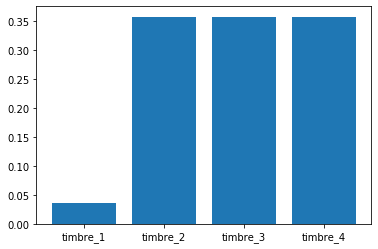

In [0]:
clusters_timbre_lp = {}
for i in range(4):
  km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=1e-04, 
              random_state=0).fit(pd.DataFrame(data={violinist: timbre_resampled_lowpass_table.loc[violinist][f'timbre_{i+1}_resampled_lowpass'] for violinist in timbre_timecourses.keys()}).transpose())
  results = km.predict(pd.DataFrame(data={violinist: timbre_resampled_lowpass_table.loc[violinist][f'timbre_{i+1}_resampled_lowpass'] for violinist in timbre_timecourses.keys()}).transpose())
  clusters = {}
  for j in range(len(timbre_timecourses.keys())):
    if results[j] not in clusters:
      clusters[results[j]] = []
    clusters[results[j]].append(list(timbre_timecourses.keys())[j])
  clusters_timbre_lp[f'timbre_{i+1}'] = clusters

clusters_timbre_lp_performance = {}
for timbre in clusters_timbre_lp:
  temp_categories = [0 if violinist in clusters_timbre_lp[timbre][0] else 1 for violinist in timbre_timecourses.keys()]
  clusters_timbre_lp_performance[timbre] = homogeneity_score(ground_truth_hip, temp_categories)

plt.bar(clusters_timbre_lp_performance.keys(), clusters_timbre_lp_performance.values())
plt.show()

Nope, no difference!

### Clustering on the timbre means and standard deviations
We didn't cluster on these initially, but perhaps given that we found some differences in certain timbral components between the groups, clustering algorithms would ideally capture the two groups.

In [0]:
# let's do means only for now
timbres_mean_table = timbres_mean_std_table[[f'mean_timbre_{i+1}' for i in range(12)]]

In [0]:
km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0).fit(timbres_mean_table)
results = km.predict(timbres_mean_table)
clusters = {}
for j in range(len(timbre_timecourses.keys())):
  if results[j] not in clusters:
    clusters[results[j]] = []
  clusters[results[j]].append(list(timbre_timecourses.keys())[j])
display(clusters)

{0: ['Amandine Beyer',
  'Giuliano Carmignola',
  'Rachel Podger',
  'Hilary Hahn',
  'Itzhak Perlman',
  'Arthur Grumiaux',
  'Henryk Szeryng',
  'Midori Goto',
  'Kyung Wha Chung',
  'Gidon Kremer',
  'Aaron Rosand',
  'Lara St. John'],
 1: ['Thomas Zehetmair',
  'Enrico Onofri',
  'Lucy van Dael',
  'Sergiu Luca',
  'Monica Huggett',
  'Viktoria Mullova']}

In [0]:
temp_categories = [0 if violinist in clusters[0] else 1 for violinist in timbre_timecourses.keys()]
clusters_timbre_mean_performance = homogeneity_score(ground_truth_hip, temp_categories)
print(clusters_timbre_mean_performance)

0.45914791702724467


These did better, but were still not ideal. There may well be some optimal combination of features that give the best clusters, but finding it is pretty tricky. There are so many different combinations: for instance, there are more than 2 million subsets of size 12 alone. 

It's possible that looking at *all* features (means and standard deviations) might give us a better result, so we'll try that now.

In [0]:
timbres_mean_std_table_no_category_info = timbres_mean_std_table.drop(columns=['hip'])
km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0).fit(timbres_mean_std_table_no_category_info)
results = km.predict(timbres_mean_std_table_no_category_info)
clusters = {}
for j in range(len(timbre_timecourses.keys())):
  if results[j] not in clusters:
    clusters[results[j]] = []
  clusters[results[j]].append(list(timbre_timecourses.keys())[j])
display(clusters)

{0: ['Amandine Beyer',
  'Giuliano Carmignola',
  'Rachel Podger',
  'Hilary Hahn',
  'Itzhak Perlman',
  'Arthur Grumiaux',
  'Henryk Szeryng',
  'Midori Goto',
  'Kyung Wha Chung',
  'Gidon Kremer',
  'Aaron Rosand',
  'Lara St. John'],
 1: ['Thomas Zehetmair',
  'Enrico Onofri',
  'Lucy van Dael',
  'Sergiu Luca',
  'Monica Huggett',
  'Viktoria Mullova']}

No difference here! 

One thing to note is that all the violinists in cluster 1 are actually HIP. We're going to try doing some parallel plots to see what the clusters look like.

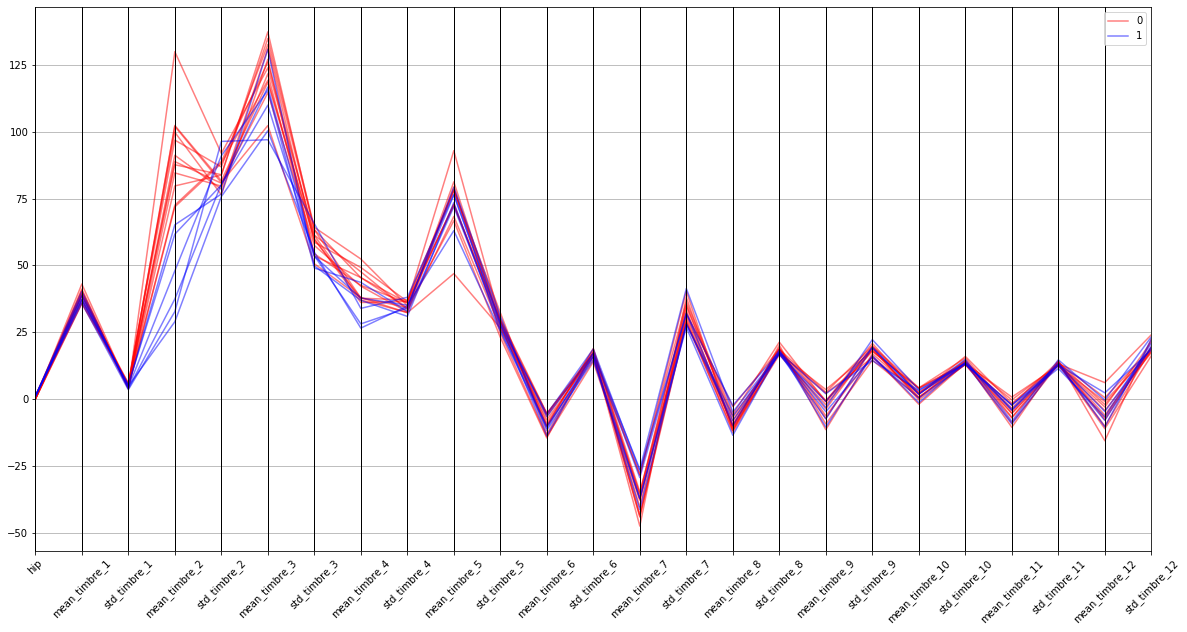

In [0]:
timbres_mean_std_table['km2_clusters'] = results
fig, ax = plt.subplots(figsize=(20,10))
timbres_mean_std_table.sort_values(by=['km2_clusters'], axis=0, ascending=True, inplace=True)
ax = pd.plotting.parallel_coordinates(timbres_mean_std_table,'km2_clusters',color=('red','blue'), alpha=0.5)
plt.xticks(rotation=45)
plt.show()

There's a lot of variance on the means of timbre components 2 and 3, which we observed before in the t-tests, that appear to be important differentiating the clusters.

Let's see if, by adding a cluster, we get the remaining HIPers out of cluster 0.

In [0]:
timbres_mean_std_table_no_category_info = timbres_mean_std_table.drop(columns=['hip'])
km = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0).fit(timbres_mean_std_table_no_category_info)
results = km.predict(timbres_mean_std_table_no_category_info)
clusters = {}
for j in range(len(timbre_timecourses.keys())):
  if results[j] not in clusters:
    clusters[results[j]] = []
  clusters[results[j]].append(list(timbre_timecourses.keys())[j])
display(clusters)

{0: ['Thomas Zehetmair',
  'Enrico Onofri',
  'Lucy van Dael',
  'Sergiu Luca',
  'Monica Huggett',
  'Viktoria Mullova',
  'Itzhak Perlman',
  'Henryk Szeryng'],
 1: ['Midori Goto',
  'Kyung Wha Chung',
  'Gidon Kremer',
  'Aaron Rosand',
  'Lara St. John'],
 2: ['Amandine Beyer',
  'Giuliano Carmignola',
  'Rachel Podger',
  'Hilary Hahn',
  'Arthur Grumiaux']}

## Timbre PCA

When I did the clustering on pianists, it was useful to see what the principal components were. Let's try the same thing this time – the routine is pretty much identical!

In [0]:
from sklearn.decomposition import PCA

In [0]:
timbres_mean_std_table_no_category_info = timbres_mean_std_table_no_category_info.drop(columns=['km2_clusters'])

In [0]:
# this gets the PCA object
pca = PCA().fit(timbres_mean_std_table_no_category_info)

In [0]:
# let's look at the amount that each principal component contributes to the overall variance of the data
for i in range(len(pca.explained_variance_ratio_)):
  print(f'PC{i+1}: {(pca.explained_variance_ratio_[i]*100):0.1f}%')

PC1: 65.5%
PC2: 13.1%
PC3: 7.4%
PC4: 4.9%
PC5: 2.7%
PC6: 1.9%
PC7: 1.3%
PC8: 1.1%
PC9: 0.7%
PC10: 0.5%
PC11: 0.5%
PC12: 0.2%
PC13: 0.2%
PC14: 0.1%
PC15: 0.0%
PC16: 0.0%
PC17: 0.0%
PC18: 0.0%


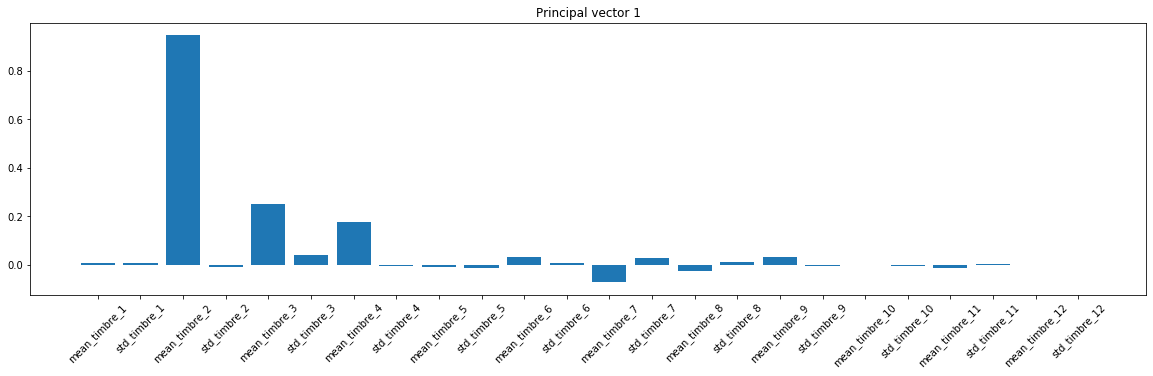

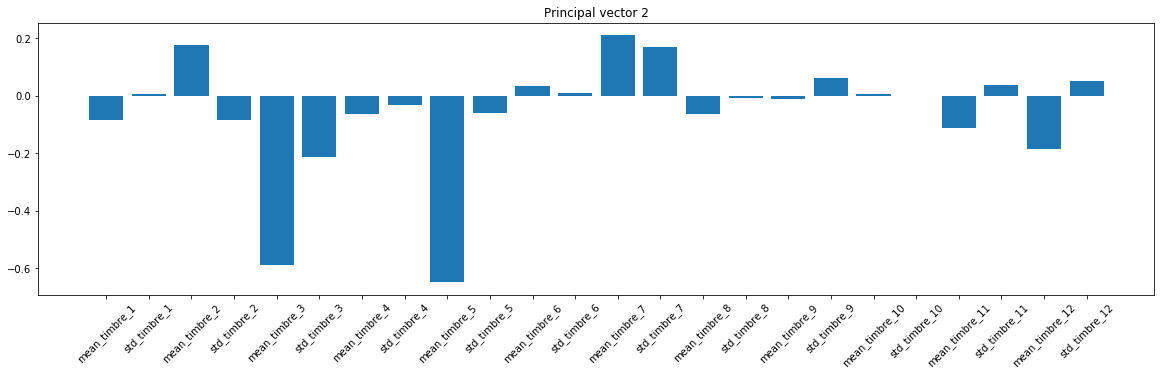

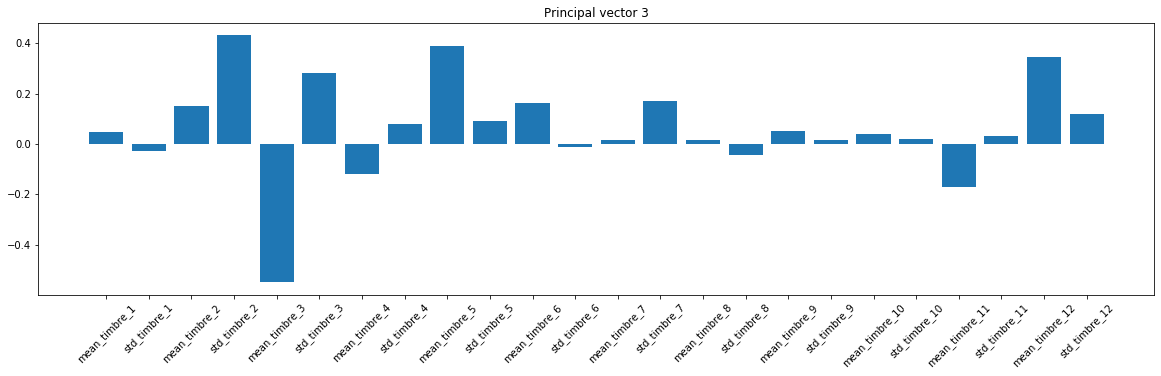

In [0]:
# let's see what the top 3 pcs look like
for i in range(3):
  plt.figure(figsize=(20,5))
  plt.bar(np.arange(24), pca.components_[i])
  plt.xticks(np.arange(24), timbres_mean_std_table_no_category_info.columns, rotation=45)
  plt.title(f'Principal vector {i+1}')
  plt.show()

**PC1**: lots of mean_timbre2, small positive mean_timbre3 and mean_timbre4. This suggests bright timbres with a relatively flat sustain and stronger than average attack.

**PC2**: large negative mean_timbre3 and mean_timbre5 vs. small positive mean_timbre2 and mean_timbre7. This suggests timbres with a lack of spectral flatness and the opposite harmonic profile to timbre component 5 (two intense bands alternating with two bare bands), with a reasonably bright timbre and whatever timbre component 7 means (I don't think this was ever determined before).

**PC3**: opposing the mean of timbre component 3 with the means of components 5 and 12, as well as the standard deviation in components 2 and 3.

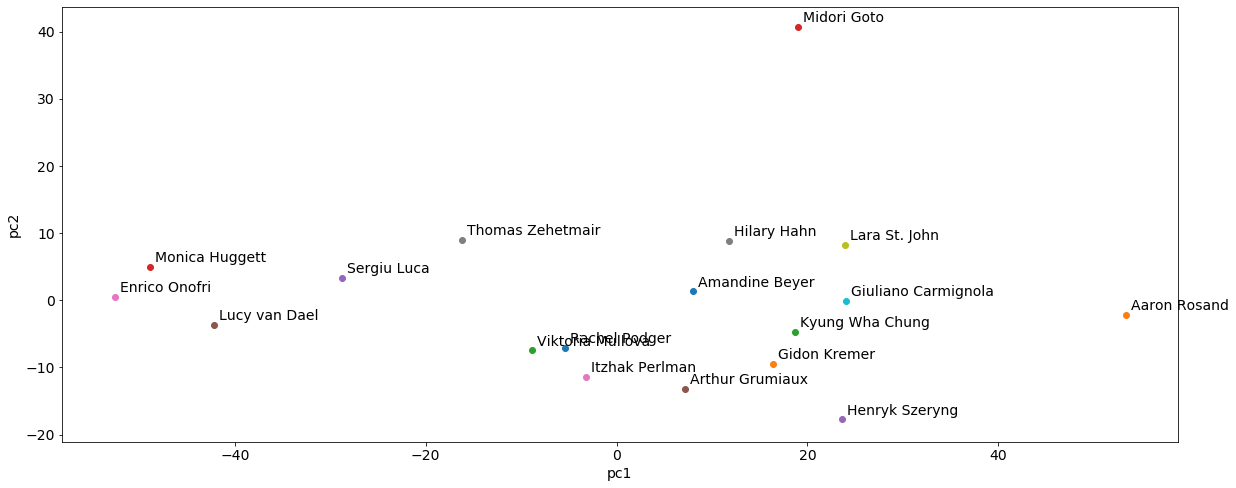

In [0]:
timbre_pcs1and2 = PCA(n_components=2).fit_transform(timbres_mean_std_table_no_category_info)
plt.figure(figsize=(20,8))
plt.rc('font', size=14) 
for i in range(len(timbre_pcs1and2)):
  x_coord = timbre_pcs1and2[i][0]
  y_coord = timbre_pcs1and2[i][1]
  label = timbres_mean_std_table_no_category_info.index[i]
  plt.scatter(x_coord,y_coord)
  plt.annotate(label, xy=(x_coord,y_coord), xytext=(5,5), textcoords='offset points')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()

There seems to be a reasonably good separation between HIP and mainstream players just looking at the first 2 pcs. This is probably all the info we need since these components account for nearly 80% of the variance. The 3D plot is a little overkill but I've put it below. In general it seems that HIP performers have darker, less flat (more "sculpted") timbre compared to the mainstream performers, based on their primarily negative PC1 loading. Amandine Beyer and Guilano Carmignola stray a little into the brighter territory, but they aren't too far over. This is probably what contributed to their being in the cluster with all the mainstream performers.

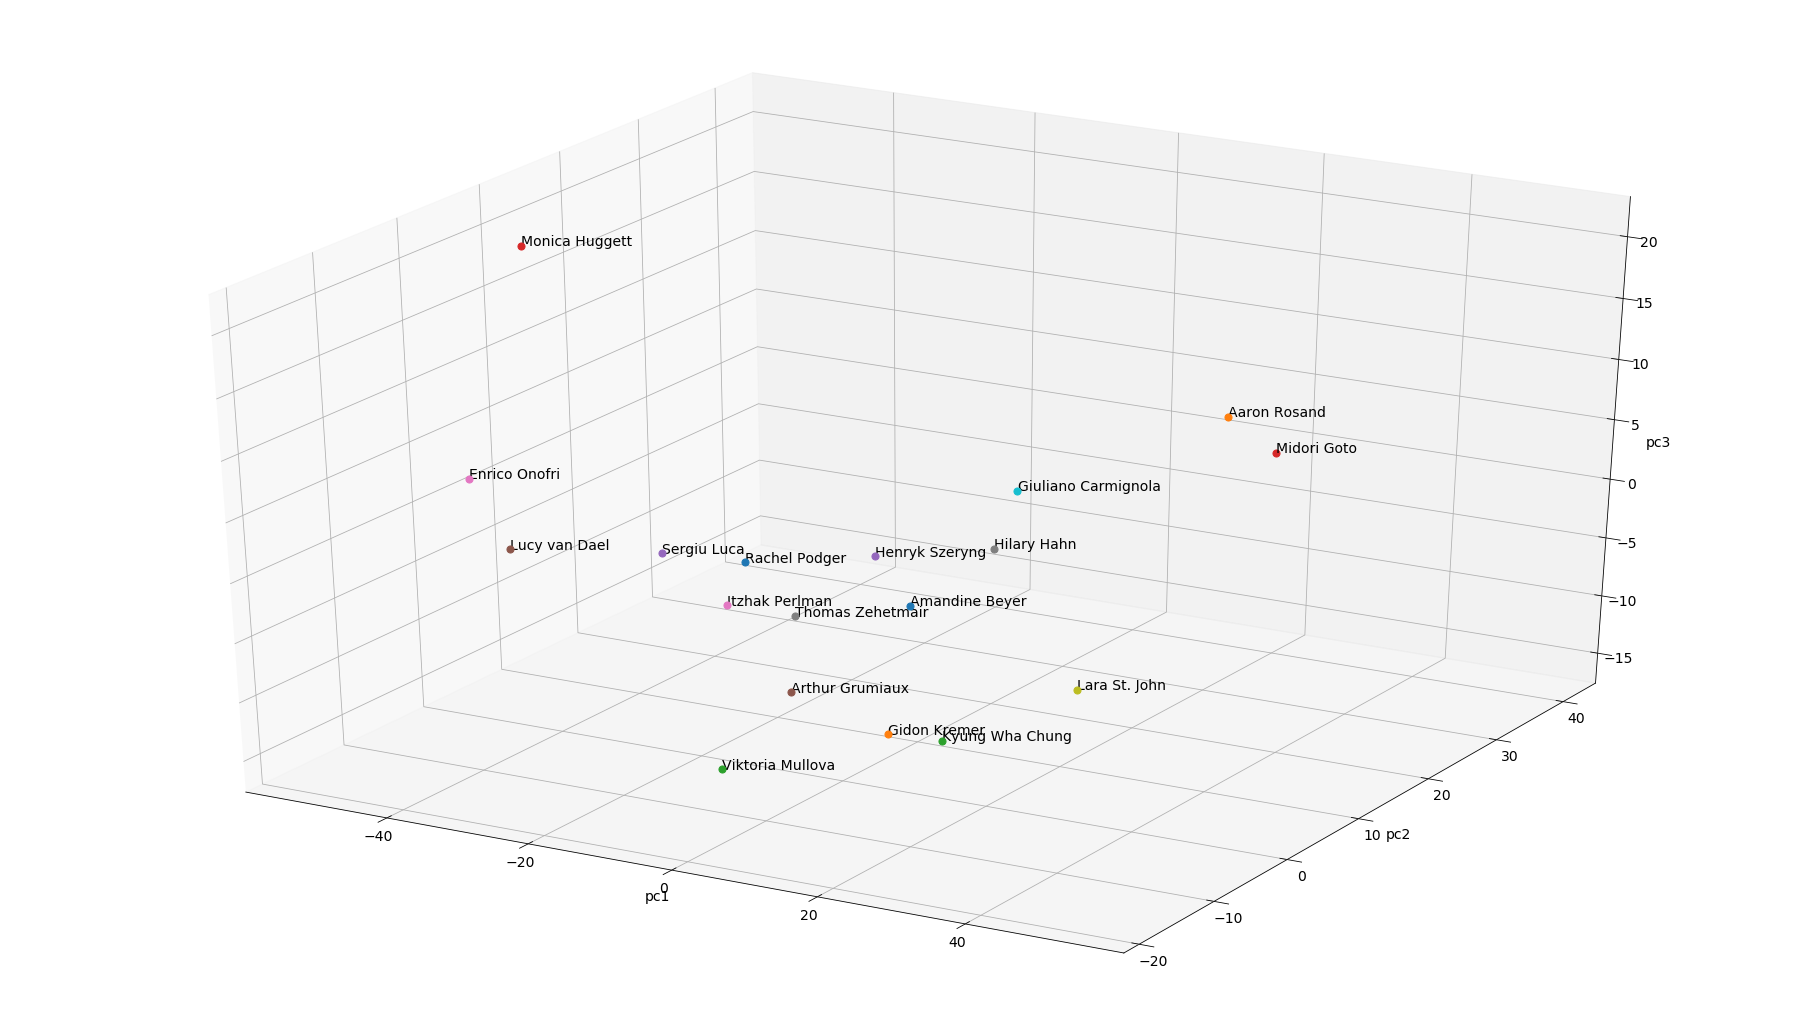

In [0]:
from mpl_toolkits.mplot3d import Axes3D
timbre_pcs123 = PCA(n_components=3).fit_transform(timbres_mean_std_table_no_category_info)

fig = plt.figure(figsize=(25,14))
plt.rc('font', size=14) 
ax = Axes3D(fig)
for i in range(len(timbre_pcs123)):
  x_coord = timbre_pcs123[i][0]
  y_coord = timbre_pcs123[i][1]
  z_coord = timbre_pcs123[i][2]
  label = timbres_mean_std_table_no_category_info.index[i]
  ax.scatter(x_coord,y_coord,z_coord,s=50)
  ax.text(x_coord+0.005,y_coord+ 0.005,z_coord-0.005, label)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.show()